In [1]:
import torch
import torch.nn.functional as F
import torchsde

from torchvision import datasets, transforms

import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import functorch

import gc

import matplotlib.pyplot as plt

from cfollmer.evaluation_utils import ECE
import cfollmer.functional as functional
from cfollmer.objectives import relative_entropy_control_cost
from cfollmer.drifts import SimpleForwardNetBN
from cfollmer.sampler_utils import FollmerSDE

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class LeNet5(torch.nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            torch.nn.Tanh(),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            torch.nn.Tanh(),
            torch.nn.AvgPool2d(kernel_size=2),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(in_features=256, out_features=120),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [4]:
MNIST_train = datasets.MNIST("../data/mnist/", download=True, transform=ToTensor(), train=True)
MNIST_test = datasets.MNIST("../data/mnist/", download=True, transform=ToTensor(), train=False)

N_train = len(MNIST_train)
N_test = len(MNIST_test)

In [5]:
model = LeNet5(10).to(device)
func_model, params = functorch.make_functional(model)
size_list = functional.params_to_size_tuples(params)
dim = functional.get_number_of_params(size_list)
  
sigma2 = 0.1

def log_prior(params):
    return -torch.sum(params**2) / (2 * sigma2)

def log_likelihood(x, y, params):
    preds = func_model(functional.get_params_from_array(params, size_list), x)
    return -F.cross_entropy(preds, y, reduction="sum")

def log_likelihood_batch(x, y, params_batch):
    func = lambda params: log_likelihood(x, y, params)
    func = functorch.vmap(func)
    return func(params_batch)

def log_posterior(x, y, params):
    return log_prior(params) + (N_train / x.shape[0]) * log_likelihood(x, y, params)

def log_posterior_batch(x, y, params_batch):
    func = lambda params: log_posterior(x, y, params)
    func = functorch.vmap(func)
    return func(params_batch)

In [6]:
def train(gamma, n_epochs, data_batch_size, param_batch_size, dt=0.05):
    sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=dim, width=300)).to(device)
    optimizer = torch.optim.Adam(sde.parameters(), lr=1e-5)
    
    dataloader_train = DataLoader(MNIST_train, shuffle=True, batch_size=data_batch_size, num_workers=2)

    losses = []

    for _ in range(n_epochs):
        epoch_losses = []
        for x, y in tqdm(iter(dataloader_train)):
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
        
            partial_log_p = lambda params_batch: log_posterior_batch(x, y, params_batch)
            
            loss = relative_entropy_control_cost(sde, partial_log_p, param_batch_size=param_batch_size, dt=dt, device=device)
            loss.backward()

            epoch_losses.append(loss.detach().cpu().numpy())
            optimizer.step()
            
        #  Memory leaks somewhere with sdeint / param_T = param_trajectory[-1]
        gc.collect()

        losses.append(epoch_losses)
    
    losses = np.array(losses)
    
    return sde, losses

In [7]:
gamma = 0.1**2
n_epochs = 10
data_batch_size = 32
param_batch_size = 32

In [8]:
sde, losses = train(gamma, n_epochs, data_batch_size, param_batch_size, dt=0.05)

  0%|                                                                       | 0/1875 [00:00<?, ?it/s]/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/nn/functional.py:2384: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-b9xxrrfi/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/nn/functional.py:2948: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::cross_entropy_loss. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-b9xxrrfi/functorch/csrc/BatchedFallback.cpp:106.)
  return torch._C._nn.cross_entropy_loss(i

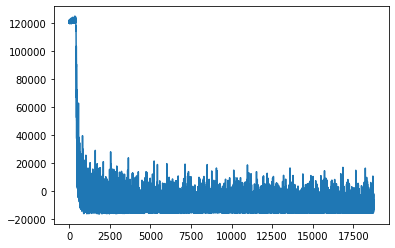

In [9]:
plt.plot(losses.flatten())

In [13]:
torch.save(sde.state_dict(), "weights/bnn/weights.pt")

In [8]:
sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=dim, width=300)).to(device)
sde.load_state_dict(torch.load("weights/bnn/weights.pt"))

<All keys matched successfully>

In [25]:
with torch.no_grad():
    param_samples = sde.sample(100, dt=0.005, device=device)

In [23]:
def evaluate(param_samples):
    dataloader_test = DataLoader(MNIST_test, shuffle=False, batch_size=data_batch_size, num_workers=2)
    
    all_predictions = []
    all_confidences = []
    all_logps = []
    
    for x, y in tqdm(iter(dataloader_test)):
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)
            
            predict_func = lambda params : func_model(functional.get_params_from_array(params, size_list), x)
            predict_func = functorch.vmap(predict_func)

            out = F.softmax(predict_func(param_samples), dim=-1)
            out = torch.mean(out, dim=0)
            
            confidences, predictions = torch.max(out, dim=1)

            all_predictions.append(predictions)
            all_confidences.append(confidences)
            
            all_logps.append(torch.mean(log_likelihood_batch(x, y, param_samples)))
    
    all_predictions = torch.hstack(all_predictions).cpu().numpy()
    all_confidences = torch.hstack(all_confidences).cpu().numpy()
    true_labels = MNIST_test.targets.numpy()
    
    accuracy = np.mean(all_predictions == true_labels)
    ece = ECE(all_confidences, all_predictions, true_labels)
    
    logp = torch.sum(torch.stack(all_logps)) / N_test
    return accuracy, ece, logp

In [26]:
evaluate(param_samples)

100%|█████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 278.53it/s]


(0.9848, 0.011085429644584713, tensor(-0.0783, device='cuda:0'))

SGLD from here onwards

In [27]:
@torch.enable_grad()
def gradient(x, y, params):
    params_ = params.clone().requires_grad_(True)
    loss = log_posterior(x, y, params_)
    grad, = torch.autograd.grad(loss, params_)
    return loss.detach().cpu().numpy(), grad

In [28]:
def step_size(n):
    return 0.0001 / (1 + n)**0.5

In [29]:
def sgld(n_epochs, data_batch_size):
    dataloader_train = DataLoader(MNIST_train, shuffle=True, batch_size=data_batch_size, num_workers=2)
    params = torch.zeros(dim).float().to(device)
    losses = []
    step = 0
    for _ in range(n_epochs):
        epoch_losses = []
        for x, y in tqdm(iter(dataloader_train)):
            x = x.to(device)
            y = y.to(device)

            eps = step_size(step)
            loss, grad = gradient(x, y, params)
            params = params + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(params)
            step += 1
            epoch_losses.append(loss)
        
        losses.append(epoch_losses)
    
    param_samples = []
    
    iterator = iter(dataloader_train)
    for _ in range(100):
        x = x.to(device)
        y = y.to(device)
        
        eps = step_size(step)
        loss, grad = gradient(x, y, params)
        params = params + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(params)
        param_samples.append(params)
        step += 1
        
    param_samples = torch.stack(param_samples)
    losses = np.array(losses)
    
    return param_samples, losses

In [30]:
param_samples, losses = sgld(n_epochs, data_batch_size)

100%|███████████████████████████████████████████████████████████| 1875/1875 [00:03<00:00, 573.05it/s]


In [31]:
evaluate(param_samples)

100%|█████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 271.43it/s]


(0.9836, 0.0036015408515930724, tensor(-0.0530, device='cuda:0'))

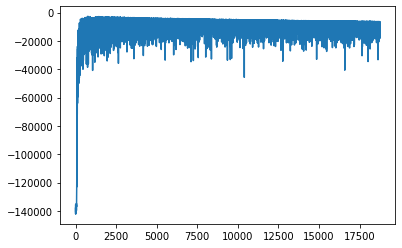

In [32]:
plt.plot(losses.flatten())